# Analysis of LLM re-ranking results

In [8]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import stylia
from stylia.colors.colors import NamedColors

df = pd.read_csv("data/curated_drugs.csv")
drug2disease = {}
for v in df[["chemical", "disease"]].values:
    drug2disease[v[0]] = v[1]

df = pd.read_csv("../results/results_pairs/chemical_gene_pairs_prediction_output_focus_with_variant_aggregates_top50_filter_llm_top10.csv")

chemicals = list(df["chemical"].unique())
cap2name = dict((c.capitalize(), c) for c in chemicals)
chemicals = sorted([c.capitalize() for c in chemicals])

drug_renames = {
    "P-aminosalicylic acid": "Aminosalicylic acid",
    "Linezolide": "Linezolid"
}

def rename_old_to_new(drug):
    drug_o_n = dict((k, v) for k, v in drug_renames.items())
    if drug in drug_o_n:
        return drug_o_n[drug]
    return drug

def rename_new_to_old(drug):
    drug_n_o = dict((v, k) for k, v in drug_renames.items())
    if drug in drug_n_o:
        return drug_n_o[drug]
    return drug

chemicals = sorted([rename_old_to_new(c) for c in chemicals])
chemicals = [rename_new_to_old(c) for c in chemicals]

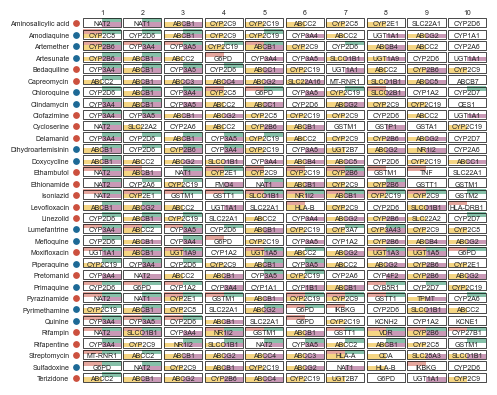

In [9]:
named_colors = NamedColors()
black = named_colors.black
green = named_colors.green
yellow = named_colors.yellow
purple = named_colors.purple
red = named_colors.red
blue = named_colors.blue
white = "white"

fig, axs = stylia.create_figure(1, 1, width=stylia.TWO_COLUMNS_WIDTH*0.7, height=stylia.TWO_COLUMNS_WIDTH*0.55)
ax = axs.next()
ax.set_ylim(len(chemicals), -1)

colors = [red, green, yellow, purple]

OFFSET = 0.47

def little_square(ax, i, j, quadrant, color):
    i = i - 0.5
    offset_h = OFFSET
    offset_v = OFFSET*0.85
    if quadrant == 0:
        offset_x = -offset_h
        offset_y = 0
    if quadrant == 1:
        offset_x = 0
        offset_y = 0
    if quadrant == 2:
        offset_x = -offset_h
        offset_y = offset_v
    if quadrant == 3:
        offset_x = 0
        offset_y = offset_v
    x = j + offset_x
    y = i + offset_y
    ax.add_patch(plt.Rectangle((x, y), offset_h, offset_v, facecolor=color, edgecolor="none", alpha=0.5, linewidth=0))

def frame(ax, i, j):
    i = i - OFFSET
    j = j - OFFSET
    ax.add_patch(plt.Rectangle((j, i), OFFSET*2, OFFSET*2*0.85, facecolor="none", edgecolor="black", linewidth=0.5))

for i in range(len(chemicals)):
    ax.text(0.2, i, rename_old_to_new(chemicals[i]), ha="right", va="center")
    if drug2disease[rename_old_to_new(chemicals[i]).lower()] == "malaria":
        color = blue
    else:
        color = red
    ax.scatter(0.37, i, color=color, s=15)
    df_ = df[df["chemical"] == cap2name[chemicals[i]]].sort_values(by="llm_rank", ascending=True).head(10)
    genes = list(df_["gene"])
    in_pgkb = []
    for x in df_[['train_set', 'train_set_pk', 'train_set_pk_adme']].sum(axis=1).tolist():
        if x == 0:
            in_pgkb += [0]
        else:
            in_pgkb += [1]
    zscores = np.clip(list(df_["consensus_zscore"]), 0, 5)
    afr_a = df_["afr_abundant_variants"].tolist()
    afr_s = df_["afr_specific_variants"].tolist()
    for j, g in enumerate(genes):
        if in_pgkb[j] == 1:
            little_square(ax, i, j+1, 0, red)
        else:
            little_square(ax, i, j+1, 0, white)
        if zscores[j] > 1.95:
            little_square(ax, i, j+1, 1, green)
        else:
            little_square(ax, i, j+1, 1, white)
        if afr_a[j] >= 50:
            little_square(ax, i, j+1, 2, yellow)
        else:
            little_square(ax, i, j+1, 2, white)
        if afr_s[j] > 0:
            little_square(ax, i, j+1, 3, purple)
        else:
            little_square(ax, i, j+1, 3, white)
        ax.text(j+1, i, g, ha="center", va="center")
        frame(ax, i, j+1)

for i in range(10):
    ax.text(i+1, -1, str(i+1), ha="center", va="center")

ax.set_ylim(len(chemicals)-0.4, -0.5)
ax.set_xlim(-0.5, 10.5)
ax.set_axis_off()
stylia.label(ax, title="", xlabel="", ylabel="")

plt.tight_layout()
plt.savefig("assets/top10_genes_per_chemical.png", dpi=300)
plt.savefig("assets/top10_genes_per_chemical.pdf", dpi=300)

## Global reranking counts in top 10

ABCB1 6
ABCC2 5
ABCG2 7
CYP2C9 6
CYP2D7 -13
CYP2S1 -12


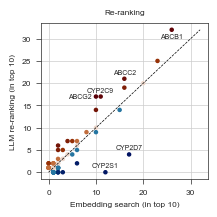

In [70]:
fig, axs = stylia.create_figure(1, 1, width=stylia.TWO_COLUMNS_WIDTH*0.3, height=stylia.TWO_COLUMNS_WIDTH*0.3)

ax = axs.next()

d50 = pd.read_csv("../results/results_pairs/chemical_gene_pairs_prediction_output_focus_with_variant_aggregates_top50_filter.csv")
d10 = pd.read_csv("../results/results_pairs/chemical_gene_pairs_prediction_output_focus_with_variant_aggregates_top50_filter_llm_top10.csv")

r50 = collections.defaultdict(list)
r10 = collections.defaultdict(list)

for v in d50[["chemical", "gene", "consensus_zscore"]].values:
    r50[v[0]].append((v[1], v[2]))

for v in d10[d10["llm_rank"].notnull()][["chemical", "gene", "llm_rank"]].values:
    r10[v[0]].append((v[1], v[2]))

r10 = dict((k, sorted(v, key = lambda x: x[1])[:10]) for k,v in r10.items())
r50 = dict((k, sorted(v, key = lambda x: -x[1])[:10]) for k,v in r50.items())

c10 = collections.defaultdict(int)
for k,v in r10.items():
    for g in v:
        c10[g[0]] += 1

c50 = collections.defaultdict(int)
for k,v in r50.items():
    for g in v:
        c50[g[0]] += 1

all_genes = sorted(set(c10.keys()).union(set(c50.keys())))

c10 = dict((k, v) for k,v in c10.items() if k in all_genes)
for g in list(all_genes):
    if g not in c10:
        c10[g] = 0

c50 = dict((k, v) for k,v in c50.items() if k in all_genes)
for g in list(all_genes):
    if g not in c50:
        c50[g] = 0

y = [c10[g] for g in all_genes]
x = [c50[g] for g in all_genes]
z = [c10[g] - c50[g] for g in all_genes]

for i, z_ in enumerate(z):
    if np.abs(z_) >= 5:
        print(all_genes[i], z_)

cmap = stylia.ContinuousColorMap("coolwarm")
cmap.fit(z)
colors = cmap.transform(z)

ax.scatter(x, y, color=colors, s=5)
ax.plot([0, 32], [0, 32], color=black, linestyle="--")

sel_genes = ["ABCB1", "ABCC2", "ABCG2", "CYP2C9", "CYP2D7", "CYP2S1"]
for i, g in enumerate(all_genes):
    if g in sel_genes:
        x_ = x[i]
        y_ = y[i]
        if g == "ABCB1":
            y_ -= 1.5
        elif g == "ABCG2":
            x_ -= 3.5
        else:
            y_ += 1.5
        ax.text(x_, y_, g, ha="center", va="center")

stylia.label(ax, title="Re-ranking", xlabel="Embedding search (in top 10)", ylabel="LLM re-ranking (in top 10)")
plt.tight_layout()

stylia.save_figure("assets/re_ranking.png")
stylia.save_figure("assets/re_ranking.pdf")